In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import matplotlib.pyplot as plt
import urllib.request

from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.optimizers import Adam
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          SpatialDropout1D,
                          Dense, 
                          Dropout)



import re
import string

In [3]:
train= pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# 데이터 프로세싱

In [6]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [7]:
tokenizer = TreebankWordTokenizer()

In [8]:
def process_text(text):
    stopwords_eng = stopwords.words('english')
    
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    html = re.compile(r'<.*?>')
    text = html.sub(r'',text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    table = str.maketrans('','',string.punctuation)
    text = text.translate(table)
    text = text.lower()
    
    tokens = tokenizer.tokenize(text)
    clean_tokens = []
    for word in tokens:
        if (word not in stopwords_eng):
            clean_tokens.append(word)
            
    return clean_tokens

In [9]:
df['text'] = df['text'].apply(lambda x : process_text(x))
df['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety...
3259    [storm, ri, worse, last, hurricane, cityamp3ot...
3260                   [green, line, derailment, chicago]
3261      [meg, issues, hazardous, weather, outlook, hwo]
3262    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 10876, dtype: object

# GLOVE

In [10]:
from tqdm import tqdm
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        corpus.append(tweet)
    return corpus

In [11]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:00<00:00, 2157354.00it/s]


In [12]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

# 데이터 정리

In [13]:
df['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety...
3259    [storm, ri, worse, last, hurricane, cityamp3ot...
3260                   [green, line, derailment, chicago]
3261      [meg, issues, hazardous, weather, outlook, hwo]
3262    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 10876, dtype: object

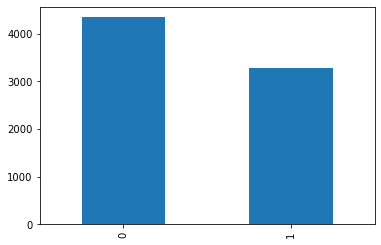

In [14]:
train['target'].value_counts().plot(kind='bar')

In [15]:
x_tweet = train['text']
y_tweet = train['target']
print('트윗 개수: {}'.format(len(x_tweet)))
print('타겟 개수: {}'.format(len(y_tweet)))

트윗 개수: 7613
타겟 개수: 7613


In [16]:
MAX_LEN=50
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)#숫자 부여
sequences=tokenizer.texts_to_sequences(corpus)#숫자에 맞춰서 생성

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [17]:
print(tweet_pad[:5])

[[5649  704  150   65 1784 3577   12    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  79    4  118  705 8372 8373 1280    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [1442 1356 2090  612 8374 1640  172 2090  612 1531 1109    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [3014    9 4341 1151  172 1531   32    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0 

In [18]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
threshold = 2
totalcount = len(word_to_index)
rarecount=0
totalfreq=0
rarefreq=0

for key, value in tokenizer.word_counts.items():
    totalfreq = totalfreq + value
    
    if(value<threshold):
        rarecount = rarecount + 1
        rarefreq = rarefreq + value

print('등장 빈도 %s 번 이하인 희귀 단어의 수 : %s'%(threshold-1, rarecount))
print('단어 집합에서 희귀 단어의 비율:', rarecount/totalcount*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', rarefreq/totalfreq*100)

등장 빈도 1 번 이하인 희귀 단어의 수 : 14300
단어 집합에서 희귀 단어의 비율: 63.07617661329452
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.905500938378209


In [19]:
embedding_matrix=np.zeros((vocab_size,100))

for word,i in tqdm(word_to_index.items()):
    if i > vocab_size:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 22671/22671 [00:00<00:00, 533004.48it/s]


In [20]:
'''x_tweet = sequences
print('트윗의 최대 길이 : %d' % max(len(l) for l in x_tweet))
print('트윗의 평균 길이 : %f' % (sum(map(len, x_tweet))/len(x_tweet)))
plt.hist([len(s) for s in x_tweet], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()'''

"x_tweet = sequences\nprint('트윗의 최대 길이 : %d' % max(len(l) for l in x_tweet))\nprint('트윗의 평균 길이 : %f' % (sum(map(len, x_tweet))/len(x_tweet)))\nplt.hist([len(s) for s in x_tweet], bins=50)\nplt.xlabel('length of samples')\nplt.ylabel('number of samples')\nplt.show()"

In [21]:
'''maxlen = 25
tweet = pad_sequences(x_tweet, maxlen = maxlen)
tweet.shape'''

'maxlen = 25\ntweet = pad_sequences(x_tweet, maxlen = maxlen)\ntweet.shape'

In [22]:
x_train=tweet_pad[:train.shape[0]]
x_test=tweet_pad[train.shape[0]:]
print('Shape of train',x_train.shape)
print("Shape of Validation ",x_test.shape)

Shape of train (7613, 50)
Shape of Validation  (3263, 50)


In [23]:
x_train

array([[5649,  704,  150, ...,    0,    0,    0],
       [  79,    4,  118, ...,    0,    0,    0],
       [1442, 1356, 2090, ...,    0,    0,    0],
       ...,
       [4060, 5579, 8035, ...,    0,    0,    0],
       [  18, 1094, 3890, ...,    0,    0,    0],
       [ 124,  127,  427, ...,    0,    0,    0]], dtype=int32)

In [24]:
y_train = train.target
y_train

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [25]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.initializers import Constant

In [26]:
model = Sequential()

embedding=Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)


model.add(embedding) # 임베딩 벡터의 차원은 100
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])


In [27]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='binary_crossentropy', patience = 3, mode='auto')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2267200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 2,347,701
Trainable params: 80,501
Non-trainable params: 2,267,200
_________________________________________________________________


In [29]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/20
96/96 [==============================] - 5s 56ms/step - loss: 0.6578 - accuracy: 0.6072 - val_loss: 0.5401 - val_accuracy: 0.7525
Epoch 2/20
96/96 [==============================] - 5s 55ms/step - loss: 0.5119 - accuracy: 0.7585 - val_loss: 0.4601 - val_accuracy: 0.7984
Epoch 3/20
96/96 [==============================] - 5s 51ms/step - loss: 0.4908 - accuracy: 0.7749 - val_loss: 0.4535 - val_accuracy: 0.7945
Epoch 4/20
96/96 [==============================] - 5s 51ms/step - loss: 0.4834 - accuracy: 0.7788 - val_loss: 0.4452 - val_accuracy: 0.8030
Epoch 5/20
96/96 [==============================] - 5s 51ms/step - loss: 0.4744 - accuracy: 0.7836 - val_loss: 0.4384 - val_accuracy: 0.8056
Epoch 6/20
96/96 [==============================] - 5s 51ms/step - loss: 0.4709 - accuracy: 0.7892 - val_loss: 0.4351 - val_accuracy: 0.8043
Epoch 7/20
96/96 [==============================] - 5s 56ms/step - loss: 0.4691 - accuracy: 0.7869 - val_loss: 0.4340 - val_accuracy: 0.8070
Epoch 8/20
96

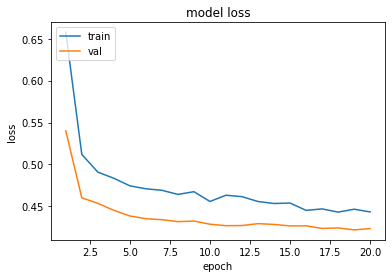

In [30]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [32]:
x_test

array([[ 667, 1362,   55, ...,    0,    0,    0],
       [ 260,  150, 1192, ...,    0,    0,    0],
       [  79,    4,  694, ...,    0,    0,    0],
       ...,
       [ 715,  442,  312, ...,    0,    0,    0],
       [4175,  500,  336, ...,    0,    0,    0],
       [4081, 2551, 1435, ...,    0,    0,    0]], dtype=int32)

In [33]:
tweet_result = model.predict(x_test)
pd_tweet_result = pd.DataFrame(tweet_result, columns=['result'])

In [34]:
pd_tweet_result

,result
0,0.929127
1,0.760512
2,0.974794
3,0.883550
4,0.976865
...,...
3258,0.961415
3259,0.973280
3260,0.749921
3261,0.720758


# KEYWORD

In [35]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [36]:
train['keyword'] = train['keyword'].fillna('0')
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')
train['target_mean'] = train['target_mean'].fillna(0.0)
train

,id,keyword,location,text,target,target_mean
0,1,0,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.688525
1,4,0,NaN,Forest fire near La Ronge Sask. Canada,1,0.688525
2,5,0,NaN,All residents asked to 'shelter in place' are ...,1,0.688525
3,6,0,NaN,"13,000 people receive #wildfires evacuation or...",1,0.688525
4,7,0,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.688525
...,...,...,...,...,...,...
7608,10869,0,NaN,Two giant cranes holding a bridge collapse int...,1,0.688525
7609,10870,0,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0.688525
7610,10871,0,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.688525
7611,10872,0,NaN,Police investigating after an e-bike collided ...,1,0.688525


In [37]:
df_key = pd.DataFrame()
df_key['keyword'] = train['keyword']
df_key['target_mean'] = train['target_mean']
df_key

,keyword,target_mean
0,0,0.688525
1,0,0.688525
2,0,0.688525
3,0,0.688525
4,0,0.688525
...,...,...
7608,0,0.688525
7609,0,0.688525
7610,0,0.688525
7611,0,0.688525


In [38]:
df_key = df_key.sort_values(by=['target_mean'])
df_key

,keyword,target_mean
115,aftershock,0.0
122,aftershock,0.0
123,aftershock,0.0
124,aftershock,0.0
125,aftershock,0.0
...,...,...
2174,debris,1.0
2173,debris,1.0
2172,debris,1.0
2170,debris,1.0


In [39]:
oh_key = pd.get_dummies(df_key['keyword'])
df_key = pd.concat([df_key,oh_key], axis = 1)
df_key

,keyword,target_mean,0,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,...,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
115,aftershock,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122,aftershock,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123,aftershock,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,aftershock,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,aftershock,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,debris,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2173,debris,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2172,debris,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2170,debris,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
key_trainx = df_key[df_key.columns[2:]]
key_trainy = df_key['target_mean'].round().astype('int64')

In [41]:
key_trainy

115     0
122     0
123     0
124     0
125     0
       ..
2174    1
2173    1
2172    1
2170    1
2181    1
Name: target_mean, Length: 7613, dtype: int64

In [42]:
testkey = test['keyword']
testkey = pd.DataFrame(testkey).fillna('0')
testkey = pd.get_dummies(testkey)
testkey.columns = df_key.columns[2:]
testkey

,0,ablaze,accident,aftershock,airplane%20accident,ambulance,annihilated,annihilation,apocalypse,armageddon,...,weapons,whirlwind,wild%20fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
def RF_model(trainx,trainy,testx):
    estimators = 500
    np.random.seed(1)
    RF_prod = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 1, min_samples_split = 2, max_depth = 24)
    RF_prod_model = RF_prod.fit(trainx, trainy)
    RF_prod_prediction = RF_prod.predict_proba(testx)[:,1]
    
    return RF_prod_prediction

In [44]:
key_predict = RF_model(key_trainx,key_trainy,testkey)
pd_keyresult = pd.DataFrame(key_predict, columns = ['target'])
pd_keyresult

,target
0,0.838778
1,0.838778
2,0.838778
3,0.838778
4,0.838778
...,...
3258,0.838778
3259,0.838778
3260,0.838778
3261,0.838778


# SUBMISSION

In [45]:
result = (pd_keyresult['target'] + pd_tweet_result['result'])/2
result = result.round().astype('int')
result

0       1
1       1
2       1
3       1
4       1
       ..
3258    1
3259    1
3260    1
3261    1
3262    1
Length: 3263, dtype: int64

In [46]:
test=pd.read_csv('../input/nlp-getting-started/test.csv')
output = pd.DataFrame({'id': test.id, 'target':result})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [47]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
